# Classifying YouTube Videos for Humpback Whale Encounters - Keras CNN-RNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import pickle
import glob
import cv2
import os
import time

from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns

In [3]:
#ngc workspace path (where we keep our data)
workspace_path = '/mount/data'

# Start WandB Session

In [4]:
import wandb

#start wandb session for metric logging
wandb.login() 

wandb.init(project="whale-classification-inception")

wandb: Currently logged in as: micheller (epg). Use `wandb login --relogin` to force relogin


# Set GPU Context

In [5]:
print("Num GPUs available: ", len(tf.config.list_physical_devices('GPU'))) #1 if we select GPU mode in Colab Notebook, 0 if running on local machine

Num GPUs available:  2


In [7]:
# gpus = tf.config.list_physical_devices('GPU')
gpus = tf.config.list_logical_devices('GPU')

for gpu in gpus:
    print(gpu.name)

/device:GPU:0
/device:GPU:1


# Inception V3 (CNN-RNN) 

## Hyperparameters

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_NUM_FRAMES = 461
NUM_FEATURES = 2048

461 frames of size 224 x 224 with RGB color channels

# Load Frames + Extract Features with CNN

In [9]:
from feature_extraction import load_frames, prepare_all_videos
from cnn import CNN

In [10]:
#create CNN Feature Extractor
ConvNet = CNN(IMG_SIZE)
feature_extractor = ConvNet.InceptionV3()
feature_extractor

In [12]:
#load dataset in
data = pd.read_csv(workspace_path + '/downloaded_videos.csv')
y = data.pop('relevant')
X = data

In [13]:
#begin keeping track of time to extract ALL frames using a single GPU
start = time.time()

with tf.device('/device:GPU:0'):
    (frame_features, frame_masks), labels = prepare_all_videos(X, y, MAX_NUM_FRAMES, NUM_FEATURES, feature_extractor)
    
stop = time.time()

print(f"Time to extract frames with single GPU: {stop - start}s")

video_0000.mp4


2022-07-11 21:43:32.420158: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400


video_0134.mp4
video_0248.mp4
video_0357.mp4
Time to extract frames with single GPU: 18351.396564483643s


In [14]:
#took 5 hours to extract features from frames with the GPU context set above
(stop-start)/60/60

5.097610156801012

In [15]:
print('Frame features shape: ', frame_features.shape)
print('Frame masks shape: ', frame_masks.shape)
print('Number of Labels: ', len(labels))

Frame features shape:  (364, 461, 2048)
Frame masks shape:  (364, 461)
Number of Labels:  364


# Training RNN Sequence Model

In [16]:
from rnn import RNN

In [17]:
rnn_model = RNN()

In [18]:
#training RNN with 5 fold cross validation

skfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
fold = 0

test_acc_per_fold       = dict()
test_loss_per_fold      = dict()
fold_train_test_indices = dict() #{'fold_model_name': [fold_train_index_list, fold_test_index_list]}

for train_index, test_index in skfold.split(X, y):
    
    print(f'Fold {fold} \n')
    
    #index data accordingly
    train_features, train_masks, train_labels = frame_features[train_index], frame_masks[train_index], np.array(labels)[train_index]
    test_features, test_masks, test_labels = frame_features[test_index], frame_masks[test_index], np.array(labels)[test_index]
    
    #reshape label arrays as horizontal arrays
    train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
    test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))
    
    #create and compile model
    rnn_model.build_model(MAX_NUM_FRAMES, NUM_FEATURES)
    rnn_model.compile_model(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")
    
    #train and evaluate the model
    rnn_model.fit(train_features, train_masks, train_labels, f'rnn_model_{fold}')
    loss, accuracy = rnn_model.evaluate(test_features, test_masks, test_labels)
    
    #store the test accuracies and loss for each fold model
    test_acc_per_fold[fold]       = accuracy
    test_loss_per_fold[fold]      = loss
    fold_train_test_indices[fold] = [train_index, test_index]
    
    fold += 1
    

Fold 0 

3/3 [==============================] - 0s 31ms/step - loss: 0.6074 - accuracy: 0.7260
Fold 1 

3/3 [==============================] - 0s 31ms/step - loss: 0.6143 - accuracy: 0.7397
Fold 2 

3/3 [==============================] - 0s 28ms/step - loss: 0.5738 - accuracy: 0.7123
Fold 3 

3/3 [==============================] - 0s 34ms/step - loss: 0.6128 - accuracy: 0.7123
Fold 4 

3/3 [==============================] - 0s 33ms/step - loss: 0.5561 - accuracy: 0.8056


In [46]:
data.shape

(364, 11)

# Fitting Model without Cross Validation

In [48]:
from sklearn.model_selection import train_test_split

#split data into 80% train, 20% test. Both test and train contain balanced class proportions (half rel, half not rel) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [61]:
from sklearn import metrics

rnn_model = RNN()

train_index = list(X_train.index)
test_index = list(X_test.index)

#index data accordingly
train_features, train_masks, train_labels = frame_features[train_index], frame_masks[train_index], np.array(labels)[train_index]
test_features, test_masks, test_labels = frame_features[test_index], frame_masks[test_index], np.array(labels)[test_index]

#reshape label arrays as horizontal arrays
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

#create and compile model
rnn_model.build_model(MAX_NUM_FRAMES, NUM_FEATURES)
rnn_model.compile_model(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

#train model
rnn_model.fit(train_features, train_masks, train_labels, f'rnn_model_{fold}')

#evaluate model on test set
loss, accuracy = rnn_model.evaluate(test_features, test_masks, test_labels)

print(f"Loss: {loss}, Accuracy: {accuracy}")

#get f1, precision, recall, support metrics
y_pred = rnn_model.predict(test_features, test_masks)
y_true = test_labels.flatten()

cm = metrics.confusion_matrix(y_true, y_pred)
precision, recall, f1, support =  metrics.precision_recall_fscore_support(y_true, y_pred)

print(f"F1: {f1}, Precision: {precision}, Recall: {recall}")

3/3 [==============================] - 0s 38ms/step - loss: 0.6388 - accuracy: 0.7123
Loss: 0.6387816667556763, Accuracy: 0.7123287916183472
F1: [0.75862069 0.6440678 ], Precision: [0.67346939 0.79166667], Recall: [0.86842105 0.54285714]


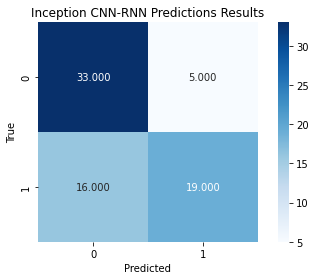

In [62]:
#plot confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Inception CNN-RNN Predictions Results')
plt.tight_layout()

In [64]:
wandb.log({'accuracy': accuracy, 'loss': loss})
wandb.finish()

accuracy,▁▁
loss,▁▁
accuracy,0.71233
loss,0.63878


## TF Distribute

In [ ]:
def get_compiled_model():
    # Make a simple 2-layer densely-connected neural network.
    inputs = keras.Input(shape=(784,))
    x = keras.layers.Dense(256, activation="relu")(inputs)
    x = keras.layers.Dense(256, activation="relu")(x)
    outputs = keras.layers.Dense(10)(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


def get_dataset():
    batch_size = 32
    num_val_samples = 10000

    # Return the MNIST dataset in the form of a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Preprocess the data (these are Numpy arrays)
    x_train = x_train.reshape(-1, 784).astype("float32") / 255
    x_test = x_test.reshape(-1, 784).astype("float32") / 255
    y_train = y_train.astype("float32")
    y_test = y_test.astype("float32")

    # Reserve num_val_samples samples for validation
    x_val = x_train[-num_val_samples:]
    y_val = y_train[-num_val_samples:]
    x_train = x_train[:-num_val_samples]
    y_train = y_train[:-num_val_samples]
    return (
        tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size),
        tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size),
        tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size),
    )


# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()

# Train the model on all available devices.
train_dataset, val_dataset, test_dataset = get_dataset()
model.fit(train_dataset, epochs=2, validation_data=val_dataset)

# Test the model on all available devices.
model.evaluate(test_dataset)